In [1]:
import pandas as pd
import seaborn as sns

from math import floor
from copy import deepcopy

import random

In [2]:
sns.set(rc={'figure.figsize': (11.7, 8.27)})

In [3]:
# Установка библиотеки sklearn
!pip3 install sklearn

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'


  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-

In [4]:
from sklearn.linear_model import LinearRegression

In [5]:
class ShuffleOnceRandom():
    """
    Генератор случайных чисел, который запрещает использовать
    функцию shuffle больше одного раза.
    """
    
    def __init__(self, seed=None):
        import random
        
        self._random_gen = random.Random(seed)
        self._shuffle_cnt = 0
        
    def shuffle(self, l):
        if self._shuffle_cnt > 0:
            raise RuntimeError('Нельзя использовать функцию shuffle больше одного раза')
            
        self._shuffle_cnt += 1
        self._random_gen.shuffle(l)

In [6]:
class ChoicesNRandom():
    """
    Генератор случайных чисел, который запрещает использовать
    функцию choices больше n раз.
    """
    
    def __init__(self, seed=None, n=1):
        import random
        
        self._random_gen = random.Random(seed)
        self._choices_cnt = 0
        self._n = n
        
    def choices(self, *args, **kwargs):
        if self._choices_cnt >= self._n:
            raise RuntimeError(f'Нельзя использовать функцию choices больше {self._n} раз')
            
        self._choices_cnt += 1
        return self._random_gen.choices(*args, **kwargs)

# Разбиение на обучающую, валидационную и тестовую выборки

In [7]:
def train_test_split_solution(data, 
                              train_frac,
                              random_gen):
    """
    Разбивает переданный список объектов на обучающую и тестовую выборки.
    
    Аргументы:
        data: Список объектов, который нужно разделить на части.
        train_frac: Доля объектов, которые нужно отправить в обучающую выборку.
        random_gen: Генератор случайных чисел.
        
    Возвращаемое значение:
        Пара списков: обучающая выборка, тестовая выборка.
    """

    data_copy = deepcopy(data)
    random_gen.shuffle(data_copy)

    len_data_train = floor(len(data_copy) * train_frac)

    data_train = data_copy[:len_data_train]
    data_test = data_copy[len_data_train:]

    return data_train, data_test    

In [8]:
def train_test_split_tests():
    example_1_data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    example_1_train_frac = 0.7
    example_1_random_gen = ShuffleOnceRandom(0)
    
    example_1_res = [8, 9, 2, 6, 4, 5, 3], [1, 10, 7]
    
    assert train_test_split_solution(example_1_data, 
                                     example_1_train_frac, 
                                     example_1_random_gen) == example_1_res
    
    
    example_2_data = [i % 5 for i in range(100)]
    example_2_train_frac = 0.9
    example_2_random_gen = ShuffleOnceRandom(0)
    
    example_2_res = [3, 3, 1, 2, 3, 3, 1, 1, 4, 4, 1, 3, 2, 1, 0, 2, 2, 2, 3, 1, 4, 1, 4, 0, 4, 0, 2, 4, 3, 2, 3, 1, 3, 4, 1, 3, 4, 3, 4, 4, 4, 0, 4, 0, 0, 1, 1, 1, 2, 2, 3, 0, 4, 0, 3, 1, 1, 0, 2, 0, 3, 2, 3, 0, 1, 0, 1, 0, 0, 4, 0, 1, 0, 2, 4, 2, 4, 3, 2, 3, 2, 4, 2, 0, 1, 2, 4, 2, 4, 0], [1, 3, 1, 2, 0, 3, 0, 3, 2, 4]
    
    assert train_test_split_solution(example_2_data, 
                                     example_2_train_frac, 
                                     example_2_random_gen) == example_2_res
    
    print('Все тесты прошли успешно!')

In [9]:
train_test_split_tests()

Все тесты прошли успешно!


# Кросс-валидация

In [10]:
def round_to_3(x):
    """
    Принимает число и возвращает результат его округления
    до 3 знаков после запятой.
    
    Аргументы:
        x: Число.
        
    Возвращаемое значение:
        Результат округления числа до 3 знаков после запятой.
    """
    
    return round(x, 3)

In [11]:
def split_into_k(l, k):
    """
    Разделяет список на k частей.
    
    Аргументы:
        l: Список с объектами.
        k: Число частей, на которые нужно разделить список.
        
    Возвращаемое значение:
        Возвращает список из k частей исходного списка.
    """
    
    l_mod_k = len(l) % k
    l_div_k = len(l) // k
    
    res = []
    
    for i in range(k):
        res.append(l[i * l_div_k:(i + 1) * l_div_k])
        
    for i in range(l_mod_k):
        res[i].append(l[l_div_k * k + i])
        
    return res

def score_model(model, x_test, y_test):
    """
    Оценивает точность модели по метрике «среднее отклонение от предсказанного значения».
    
    Аргументы:
        model: Модель.
        x_test: Список объектов тестовой выборки.
        y_test: Список значений предсказываемой характеристики для объектов из тестовой выборки.
                Значение на $i$-ой позиции в списке соответствует $i$-ому объекту тестовой выборки.
        
    Возвращаемое значение:
        Точность модели.
    """
    
    y_pred = model.predict(x_test)
    
    res = 0

    for i in range(len(y_test)):
        res += abs(y_pred[i] - y_test[i])
        
    return res / len(y_test)

In [30]:
def k_fold_solution(model, data_x, data_y, k, random_gen):
    """
    Проводит кросс-валидацию заданной модели методом k-Fold.
    
    Аргументы:
        model: Модель, точность которой нужно оценить с помощью кросс-валидации.
        data_x: Список объектов, на основе которых нужно построить модель.
                Каждый объект представлен списком значений факторов.
        data_y: Список значений предсказываемой величины для каждого из объектов.
                На $i$-ой позиции в списке data_y находится предсказываемое
                значение для $i$-го объекта из списка data_x.
             k: Количество частей, на которые нужно разбить данные при кросс-валидации.
        random_gen: Генератор случайных чисел.
        
    Возвращаемое значение:
        Усреднённая по всем итерациям k-Fold точность модели.
    """
    
    score = 0

    data_xy = list(zip(data_x, data_y))
    random_gen.shuffle(data_xy)

    data_xy = split_into_k(data_xy, k)

    for i in range(k):
        # Выбираем тестовую выборку
        test_data = data_xy[i]
        
        # Формируем тестовую выборку
        train_data = []
        for j in range(k):
            if j != i:
                train_data.extend(data_xy[j])

        x_train, y_train = zip(*train_data)
        x_test, y_test = zip(*test_data)

        # Обучаем модель
        model.fit(x_train, y_train)

        score += score_model(model, x_test, y_test)
    
    return round_to_3(score / k)

In [13]:
def k_fold_test():
    data_x_example_1 = [[1], [2], [3]]
    data_y_example_1 = [1, 2, 3]
    
    assert k_fold_solution(LinearRegression(), 
                           data_x_example_1, data_y_example_1, 3, 
                           ShuffleOnceRandom(0)) == 0.0
    
    data_example_2 = pd.read_csv('k_fold_test_data.csv')
    
    data_x_example_2 = [[x] for x in list(data_example_2['x'])]
    data_y_example_2 = list(data_example_2['y'])
    
    assert k_fold_solution(LinearRegression(), 
                           data_x_example_2, data_y_example_2, 100, 
                           ShuffleOnceRandom(0)) == 0.602
    
    print('Тест прошёл успешно!')

In [31]:
k_fold_test()

Тест прошёл успешно!


# Погрешность оценки качества

In [15]:
error_modeling_data = pd.read_csv('error_modelling.csv')

In [16]:
y = list(error_modeling_data['y'])
y_pred = list(error_modeling_data['y_pred'])

In [17]:
y_and_y_pred = list(zip(y, y_pred))

Погрешность:  0.004
Дисперсия:  1.205


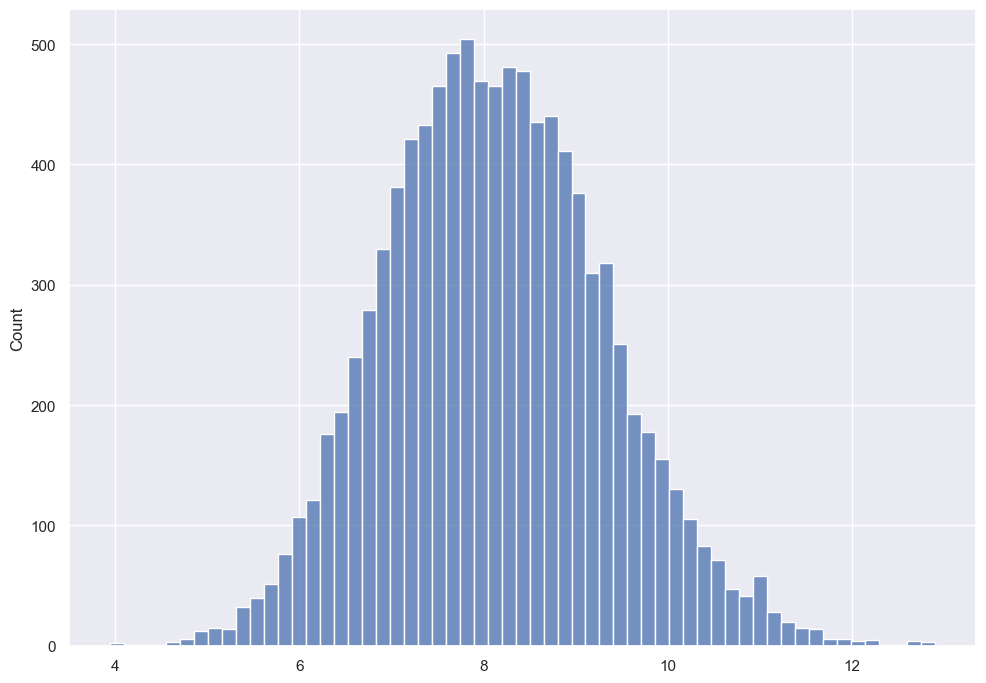

In [46]:
error_modeling_random_gen = random.Random(0)

errs = []

for i in range(10_000):
    # необходимо сгенерировать случайную выборку объектов исходного множества
    # и оценить точность работы модели на этой выборке
    
    # Генерация подмножеств
    sample_values = error_modeling_random_gen.sample(y_and_y_pred, 100)

    # Вычисление метрики (среднее отклонение от предсказанного значения)
    errs_local = 0

    y_sample, y_pred_sample = zip(*sample_values)

    for i in range(100):
        errs_local += abs(y_sample[i] - y_pred_sample[i])
    
    errs.append(errs_local / 100)

# Распределение оценок точности модели, вычисленных на случайных выборках
sns.histplot(errs)

# Среднее арифметическое оценок модели, полученных на случайных выборках
errs_mean = sum(errs) / len(errs) 

# Точность модели, оценённая по всем данным
errs_all_data = 0
for i in range(len(y)):
    errs_all_data += abs(y[i] - y_pred[i])
errs_all_data /= len(y)

print("Погрешность: ", round_to_3(abs(errs_mean - errs_all_data)))

# Дисперсия оценки 
sko_accuracy_estimates = (sum([(x - errs_mean) ** 2 for x in errs]) / len(errs)) ** 0.5

print("Дисперсия: ", round_to_3(sko_accuracy_estimates))


# Бутстрап

In [19]:
def cut_on_edges(l, fraction_to_cut):
    """
    Отбрасывает с левого и с правого концов переданного списка заданную долю элементов.
    
    Аргументы:
        l: Список элементов.
        fraction_to_cut: Доля элементов, которую нужно отбросить с каждой из сторон списка.
        
    Возвращаемое значение:
        Новый список, в котором с левого и с правого концов отборешна заданная доля элементов.
    """
    
    to_cut = floor(len(l) * fraction_to_cut)
    return l[to_cut:len(l) - to_cut]

In [56]:
def bootstrap_confidence_interval_solution(y, y_pred, fraction_to_cut, random_gen):
    """
    Вычисляет доверительный интервал для точности модели на тестовой выборке с помощью бутстрапа.
    
    Аргументы:
        y: Реальные значения предсказываемой характеристики для объектов тестовой выборки.
        y_pred: Предсказанные с помощью модели значения характеристики для объектов тестовой выборки.
                $i$-ый элемент списка y_pred соответствует предсказанию моделью
                значения под номером $i$ в списке y.
        fraction_to_cut: Доля элементов, которую нужно отбросить с каждого из концов списка полученных с помощью
                         бутстрапа значений перед получением доверительного интервала.
        random_gen: Генератор случайных чисел.
        
    Возвращаемое значение:
        Доверительный интервал для точности модели, оценённой по метрике
        «среднее отклонение от предсказанного значения».
        Представляется в виде пары значений: левая граница интервала, правая граница интервала.
    """

    errs = []

    y_and_y_pred = list(zip(y, y_pred))

    len_sample = len(y)

    for i in range(10_000):
        # Генерация бутстрэп-выборки
        sample = random_gen.choices(y_and_y_pred, k=len_sample)
        y_sample, y_pred_sample = zip(*sample) 

        # Вычисление метрики (среднее отклонение от предсказанного значения)
        errs_local = 0

        for i in range(len_sample):
            errs_local += abs(y_sample[i] - y_pred_sample[i])
    
        errs.append(errs_local / len_sample)
    
    # Генерация доверительного интервала
    errs.sort()
    confidence_interval = cut_on_edges(errs, fraction_to_cut)

    # Левая и правая границы доверительного интервала
    return round_to_3(confidence_interval[0]), round_to_3(confidence_interval[-1])

In [48]:
def bootstrap_confidence_interval_test():
    error_modeling_data = pd.read_csv('error_modelling.csv')
    
    y = list(error_modeling_data['y'])
    y_pred = list(error_modeling_data['y_pred'])
    
    y_y_pred = list(zip(y, y_pred))
    
    random_gen = random.Random(0)
    y_y_pred_example_1 = random_gen.sample(y_y_pred, 100)
    
    y_example_1 = [x[0] for x in y_y_pred_example_1]
    y_pred_example_1 = [x[1] for x in y_y_pred_example_1]
    random_gen_example_1 = ChoicesNRandom(0, n=10000)
    
    res_example_1 = 7.178, 13.509
    
    assert bootstrap_confidence_interval_solution(y_example_1, y_pred_example_1, 0.025, random_gen_example_1) == res_example_1
    
    print('Тест прошёл успешно!')

In [57]:
bootstrap_confidence_interval_test()

Тест прошёл успешно!
